<a href="https://colab.research.google.com/github/LorenzoMauri/Advanced-Machine-Learning/blob/main/Copy_of_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import os 
from scipy import ndimage
from tensorflow.keras.applications import vgg16
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
import time
from skimage import transform 
from keras.layers import Flatten, Dense, Input,Dropout
from keras.engine import  Model


def createFolder(folder) : 
    if not os.path.exists(folder):
        os.mkdir(folder)
     
      
def rotateImage(image,degree,folderPath):
    im=plt.imread(image)
    rotated = ndimage.rotate(im, degree)
    np.save(folderPath,rotated)

def reshape(image,shape):
  return transform.resize(image,shape)

def deleteLastChannel(image):
    return image[:,:,:3]  #tolgo il quarto canale corrispondente alla luminosità, mantenendo i primi 3 



In [ ]:
def trainModel(model,training,test,
               epochs=12,
               loss_func = keras.optimizers.Adam()):
  
  model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=loss_func,
            metrics=['accuracy'])

  # training
  modello = model.fit(x = training, validation_data = test, epochs = epochs,batch_size = 128)
  
  return modello

def plotPerformance(modello):
  fig = plt.figure(figsize = [8,5])
  plt.subplot(1, 2, 1)
  plt.title('accuracy')
  plt.plot(modello.history['accuracy'],label='training',marker='.')
  plt.plot(modello.history['val_accuracy'],label='validation',marker='.')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('loss')
  plt.plot(modello.history['loss'],label='training',marker='.')
  plt.plot(modello.history['val_loss'],label='validation',marker='.')
  plt.legend()
    
  plt.show()

def buildModel(model_type,
               input_shape = (224,224,3),units_final_layer=4):
  if model_type == 'mobilenet' : 
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
  else :  base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
    
    
  # blocco i layer pre-allenati in modo tale che durante le epoch rimangano fissi
  for layer in base_model.layers:
      layer.trainable = False

  # parte finale del modello di base
  x = base_model.output
  x = Flatten()(x)
  x = Dense(10, activation='relu', name='fullyConnected_0')(x)
  x = Dropout(0.5)(x)
  
  x = Dense(10, activation='relu', name='fullyConnected_1')(x)
  x = Dense(units_final_layer, activation='softmax', name='predictions')(x)

  # Modello
  model = Model(inputs=base_model.input, outputs=x)
  return model

In [ ]:
def DataLoader(preprocessing_function,dataAugmentation=False,base_path='/content/drive/MyDrive/indoorCVPR_09/'):
 
  # decido se fare data augmentation o meno  
  if dataAugmentation == False : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,rescale = 1. / 255)
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function, rescale = 1. / 255)
  else : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                      rescale = 1./255,
                                      zoom_range=0.6
                                      )
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                      rescale = 1./255,
                                      zoom_range=0.6                                 
                                      )
  
  # importo i dati 
  training = train_datagen.flow_from_directory(directory=base_path+'RotatedImages',
                                                  target_size=(48, 48),
                                                  color_mode="rgb",
                                                  batch_size=128,
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=1)

   
  test = test_datagen.flow_from_directory(directory=base_path+'RotatedTestImages',
                                             target_size=(48, 48),
                                             color_mode="rgb",
                                             batch_size=128,
                                             class_mode="categorical",
                                             shuffle=True,
                                             seed = 1 )
  return training,test

# Dataset indoorCVPR_09 




---



In [ ]:
from tensorflow.keras.applications import mobilenet_v2
model_built = buildModel(model_type='mobilenet',units_final_layer=4)


In [ ]:
model_built.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
training,test = DataLoader(preprocessing_function = mobilenet_v2.preprocess_input,base_path = '/content/drive/MyDrive/indoorCVPR_09/')

Found 21293 images belonging to 4 classes.
Found 5352 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


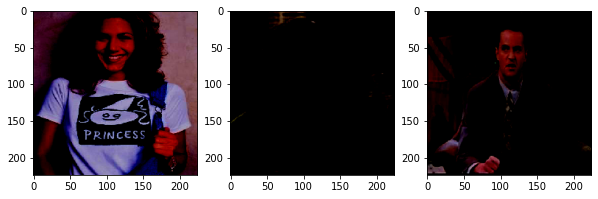

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]
plt.subplot(1,3,1); plt.imshow(training[0][0][1]); 
plt.subplot(1,3,2); plt.imshow(training[0][0][2]); 
plt.subplot(1,3,3); plt.imshow(training[0][0][3]); 
plt.show()

In [ ]:
model_trained_vgg= trainModel(model_built,training,test)

Epoch 1/12
  2/167 [..............................] - ETA: 1:22:11 - loss: 1.3912 - accuracy: 0.3027

KeyboardInterrupt: ignored

In [ ]:
data_dir = '/content/drive/MyDrive/Images'
os.chdir(data_dir)

In [ ]:
for degree in [0,90,180,270]:
  newFolderName = f"rotated_{degree}"
  createFolder(newFolderName)  
  rotate(newFolderName)



---


## Test zone 



---



In [ ]:
import tensorflow as tf 

In [ ]:
df = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


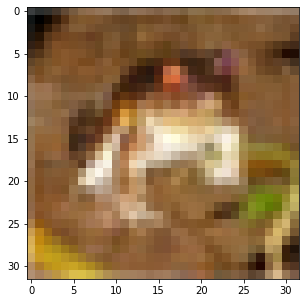

In [ ]:
plt.imshow(df[0][0][0])

In [ ]:
im=plt.imread('/content/drive/MyDrive/indoorCVPR_09/RotatedImages/180/000000.jpg')

In [ ]:
from keras.layers import Conv2D,Input,MaxPooling2D,Dense,Flatten

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(48,48,3)),
        Conv2D(32, kernel_size=(3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128,activation='relu'),
        Dense(4, activation="softmax"),
    ]
)


In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

# training
modello = model.fit(x = training, validation_data = test, epochs = 10,batch_size = 128)
  

Epoch 1/10


KeyboardInterrupt: ignored